In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display
from matplotlib.widgets import Button, Slider
from ipywidgets import interact, IntSlider

%matplotlib ipympl
from ipywidgets import interact
from mpl_interactions import ipyplot as iplt

import math
from scipy.stats import dirichlet


from collections import OrderedDict

from trails.mtmc.ml.direct.optimized import log_ml
from trails.mtmc.common import calc_mixed_hypothesis
import trails.transition_probabilities as tp
import trails.randomwalk.randomwalk as rw
import trails.randomwalk.next_state as next_state
import trails.randomwalk.keep_walking as keep_walking
import trails.randomwalk.first_state as first_state
import trails.group_assignment as group_assignment
import trails.mtmc.common as common
import trails.utils as utils
import trails.plot as pl
import trails.mtmc.ml.deterministic.default as deterministic

from metropolis_hastings.mh_algo import metropolis_hastings

C:\Users\Max\AppData\Local\Temp\ipykernel_11048\952624435.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# graph
n_states = 100
p_state_classes = 3 * [1 / 3]
n_state_classes = len(p_state_classes)
graph = nx.barabasi_albert_graph(n_states, int(n_states * 0.10))
adjacency_matrix = np.asarray(nx.to_numpy_array(graph))
state_classes = np.zeros(n_states, dtype=int)
for i in range(n_states):
    state_classes[i] = np.arange(n_state_classes, dtype=int)[np.mod(i, n_state_classes)]


plt.close()
plt.rcParams['figure.figsize'] = 12, 8

# hypotheses
tp_group_homo = tp.group_homo(adjacency_matrix, state_classes)
hyp_groups_homo = tp_group_homo
next_homo = next_state.init_grouped_matrix( \
    group_assignment.walker, \
    tp_group_homo)

In [3]:
# transition matrices for walkers

tp_random = tp.random(adjacency_matrix, state_classes)
tp_links = tp.links(adjacency_matrix, state_classes)
tp_group_homo = tp.group_homo(adjacency_matrix, state_classes)
tp_group_homo_weighted = tp.group_homo_weighted(4, adjacency_matrix, state_classes)

# get two more similar transition matrices for the two groups
tp_similar = np.array([tp_group_homo[0], tp_group_homo_weighted[1]])
hyp_similar = tp_similar


# hypotheses (single)

hyp_teleport = utils.norm1_2d(np.ones((n_states, n_states)))
hyp_links = utils.norm1_2d(adjacency_matrix)
hyp_red = utils.norm1_2d(tp_group_homo[0])
hyp_blue = utils.norm1_2d(tp_group_homo[1])
hyp_green = utils.norm1_2d(tp_group_homo[2])

# hypotheses (mixed colours)

hyp_rb = utils.norm1_2d(hyp_red + hyp_blue) 
hyp_rg = utils.norm1_2d(hyp_red + hyp_green) 

hyp4 = np.array([hyp_rb, hyp_rg, hyp_blue, hyp_green])

# hypotheses (groups)

hyp_groups_homo = tp_group_homo
hyp_groups_homo_weighted = tp_group_homo_weighted

hyp_groups_memory = np.array([hyp_links, hyp_groups_homo[0], hyp_groups_homo[1]])
hyp_groups_memory_weighted = np.array([hyp_links, hyp_groups_homo_weighted[0], hyp_groups_homo_weighted[1]])

hyp2 = np.array([hyp_groups_homo[0], hyp_groups_homo[1], hyp_links])
hyp = np.array([hyp_links, hyp_links, hyp_groups_homo[0]])

# hypotheses (direct)

number_of_groups = [2,3]
hyp_cart_homo_weighted = tp.expand(hyp_groups_homo_weighted, number_of_groups, 0)
hyp_cart_memory_weighted = tp.expand(hyp_groups_memory_weighted, number_of_groups, 1)

hyp_cart_homo = tp.expand(hyp_groups_homo, number_of_groups, 0)
hyp_cart_memory = tp.expand(hyp_groups_memory, number_of_groups, 1)


# next_step functions for different walker types to determine their next move

next_random = next_state.init_matrix(\
        tp_random)

next_links = next_state.init_matrix(\
        tp_links)

next_homo = next_state.init_grouped_matrix(\
        group_assignment.walker, \
        tp_group_homo)

next_memory = next_state.init_grouped_matrix(\
        group_assignment.memory, \
        [tp_links, tp_group_homo[0], tp_group_homo[1]])

next_homo_weighted = next_state.init_grouped_matrix(\
        group_assignment.walker, \
        tp_group_homo_weighted)

next_memory_weighted = next_state.init_grouped_matrix(\
        group_assignment.memory, \
        [tp_links, tp_group_homo_weighted[0], tp_group_homo_weighted[1]])


# violet walkers: we consider violet walkers, where each transition based on the walkers inconsistency
def violet_group(walk, walker, adjacency_matrix, state_properties):
    group = np.random.choice(len(walker), p=walker)
    return group
next_violet = next_state.init_grouped_matrix(violet_group, tp_group_homo_weighted)

next_similar = next_state.init_grouped_matrix(group_assignment.walker, tp_similar)
next_violet_similar = next_state.init_grouped_matrix(violet_group, tp_similar)

In [4]:
# mixed trails specific function to calculate the values for the current state needed to calculate the acceptance ratio
def calc_values(curr_state, kappa=10000, smoothing=0, n_samples=10):
    group_assignment_p_curr = np.repeat(np.array([curr_state]), n_random_walkers * n_steps, axis=0)
    alpha_curr = calc_mixed_hypothesis(group_assignment_p_curr, hyp4)
    log_likelihood_curr = log_ml(transitions, group_assignment_p_curr, alpha_curr * kappa, smoothing=smoothing, n_samples=n_samples)

    return log_likelihood_curr, prior.pdf(curr_state)

# dirichlet proposal distribution
def dirichlet_proposal(curr_state, concentration_factor=1, c2=1):
    proposed_state = dirichlet.rvs(alpha=4*[0.5], size=1).reshape(len(curr_state))  
    # problem: dirichlet samples with zero entries cannot be used as new parameters for the dirichlet proposal dist
    mask = (proposed_state == 0)
    proposed_state[mask] = 0.001
    counts = mask.sum()
    proposed_state[np.argmax(proposed_state)] -= counts * 0.001

    proposal_ratio = dirichlet.pdf(curr_state, 4*[0.5]) / dirichlet.pdf(proposed_state, 4*[0.5])
    return proposed_state, proposal_ratio

# Data [1/3, 1/3, 1/3]

In [5]:
# walker data
n_random_walkers = 100
n_steps = 10
p_dist = 3 * [1/3]
n_random_walker_classes = len(p_dist)
random_walker_class_counts = np.random.multinomial(n_random_walkers, p_dist)
random_walker_class_counts = np.array(np.array(p_dist) * n_random_walkers).astype(int)
random_walker_classes = np.repeat(range(n_random_walker_classes), random_walker_class_counts)

r = rw.RandomWalk(adjacency_matrix, state_classes)
walks = r.walk(random_walker_classes, next_homo, keep_walking.init_fixed(n_steps), first_state.random)
transitions = np.concatenate([list(zip(walk[:-1], walk[1:])) for walker, walk in walks])
print(random_walker_class_counts)

[33 33 33]


In [6]:
import trails.mtmc.ml.direct.optimized as directo

kappas_base = [0, 0.001,0.003, 0.01, 0.03, 0.1, 0.3,1,3,10,30,100,300,1000,3000,10000,30000,100000,300000,1000000]

def run_exp(group_assignment_p, hyp, data):
    return {"x": kappas_base, "y": [directo.log_ml(
        transitions = data, 
        group_assignment_p = group_assignment_p, 
        alpha = np.array([a * k for a in hyp]),
        smoothing = 1,
        n_samples = 10) for k in kappas_base]}

def run_exp2(group_assignment_p, hyp, data, kappa):
    return directo.log_ml(
        transitions = data, 
        group_assignment_p = group_assignment_p, 
        alpha = np.array([a * kappa for a in hyp]),
        smoothing = 1,
        n_samples = 10)

# Hypotheses: [rb, rg, b, g]

## [rb, rg, b] bzw. g=0

In [8]:
# the group assignment probability is the same for each transition

ps = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
qs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

k = 1000

experiments_1 = pd.DataFrame(np.nan, index=ps, columns=qs)
for p in ps:
    for q in qs:
        if round(1-p-q, 1) >= 0:
            p_dist = np.array([p, q, round(1-p-q, 1)])
            group_assignment_p = np.repeat(np.array([p_dist]), n_random_walkers * n_steps, axis=0)  
            experiments_1.loc[p, q] = run_exp2(group_assignment_p, common.calc_mixed_hypothesis(group_assignment_p, hyp4[:3]), transitions, k)
        else: continue

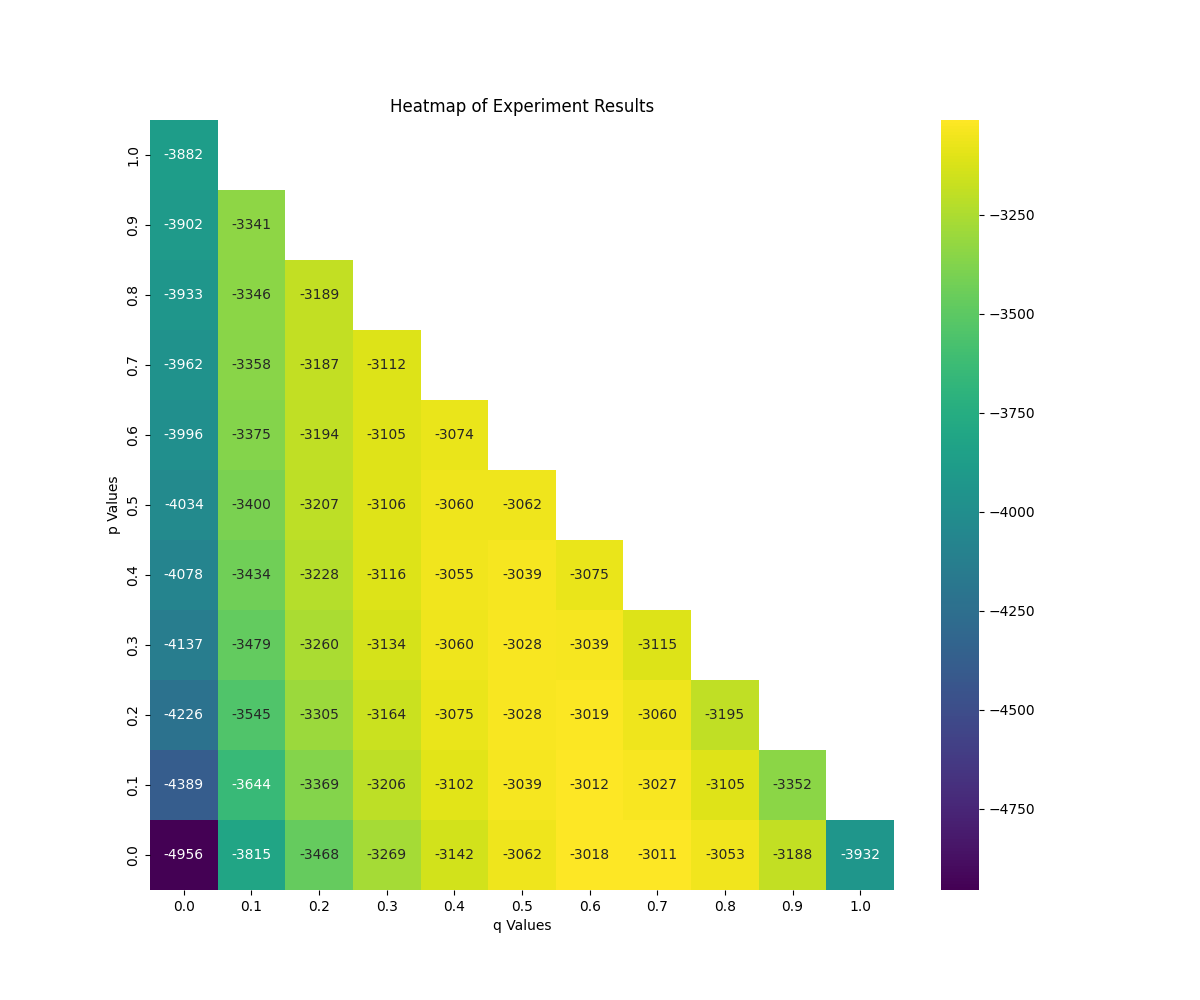

In [9]:
plt.close()
plt.figure(figsize=(12, 10))
sns.heatmap(experiments_1.reindex(index=experiments_1.index[::-1]), annot=True, cmap='viridis', fmt=".0f")
plt.title('Heatmap of Experiment Results')
plt.xlabel('q Values')
plt.ylabel('p Values')
plt.show()

## [rb, b, g] bzw. rg=0

In [10]:
# the group assignment probability is the same for each transition

ps = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
qs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

k = 1000

experiments_2 = pd.DataFrame(np.nan, index=ps, columns=qs)
for p in ps:
    for q in qs:
        if round(1-p-q, 1) >= 0:
            p_dist = np.array([p, q, round(1-p-q, 1)])
            group_assignment_p = np.repeat(np.array([p_dist]), n_random_walkers * n_steps, axis=0)  
            experiments_2.loc[p, q] = run_exp2(group_assignment_p, common.calc_mixed_hypothesis(group_assignment_p, np.delete(hyp4, 1, axis=0)), transitions, k)
        else: continue

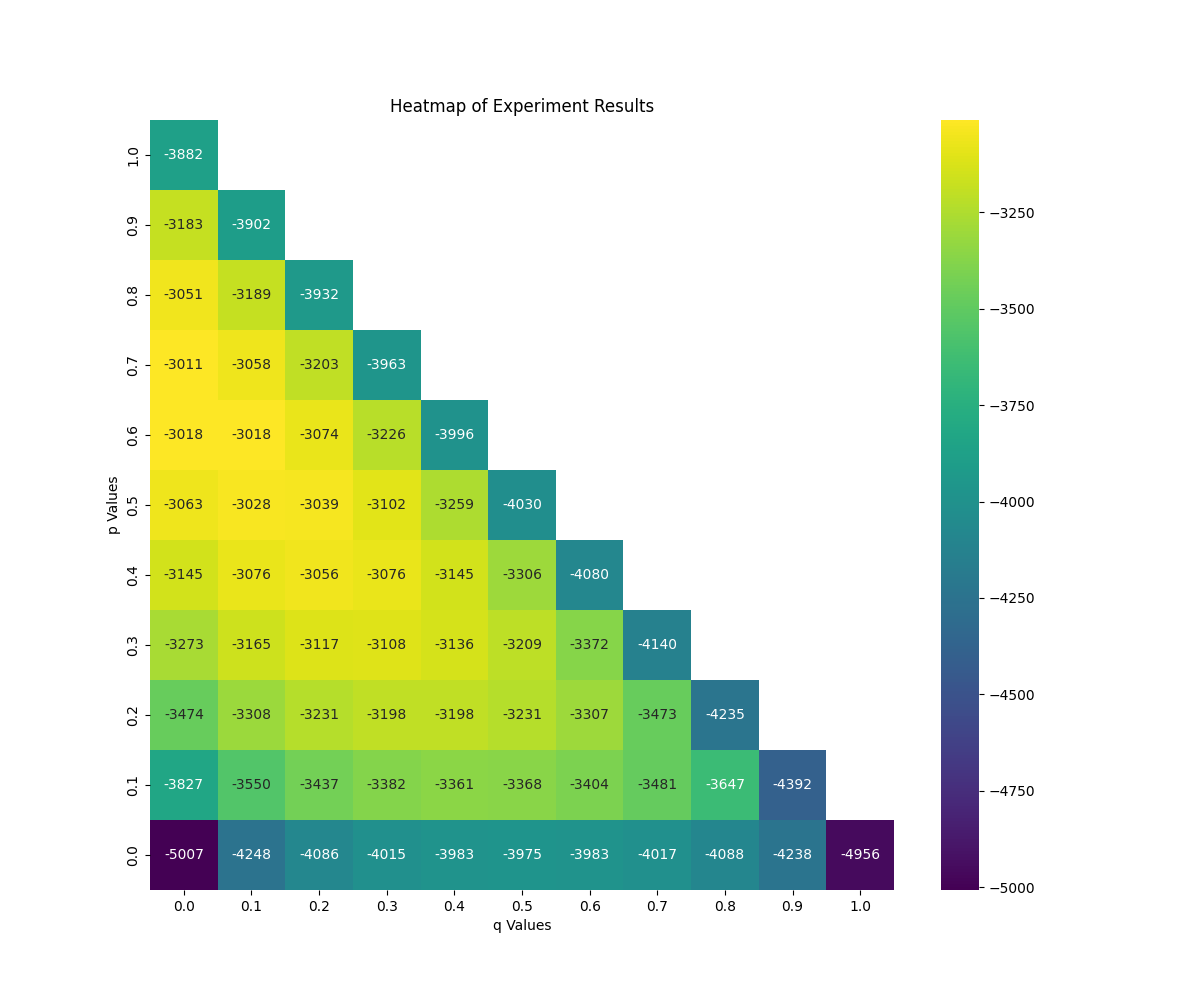

In [11]:
plt.close()
plt.figure(figsize=(12, 10))
sns.heatmap(experiments_2.reindex(index=experiments_1.index[::-1]), annot=True, cmap='viridis', fmt=".0f")
plt.title('Heatmap of Experiment Results')
plt.xlabel('q Values')
plt.ylabel('p Values')
plt.show()

In [12]:
p_dist = np.array([1/3, 1/3, 1/6, 1/6])
#p_dist = [2/3, 0, 0, 1/3]

group_assignment_p = np.repeat(np.array([p_dist]), n_random_walkers * n_steps, axis=0) 
kappa = 1000
directo.log_ml(
        transitions = transitions, 
        group_assignment_p = group_assignment_p, 
        alpha = np.array([a * kappa for a in common.calc_mixed_hypothesis(group_assignment_p, hyp4)]),
        smoothing = 1,
        n_samples = 10)

-3012.105357772666

In [13]:
p_dist = [[1/3, 1/3, 1/6, 1/6], [2/3, 0, 0, 1/3], [0, 2/3, 1/3, 0]]

experiments = OrderedDict()
for p in p_dist:
    p = np.array(p)
    group_assignment_p = np.repeat(np.array([p]), n_random_walkers * n_steps, axis=0)  
    experiments[f"ɣ={p}"] = run_exp(group_assignment_p, common.calc_mixed_hypothesis(group_assignment_p, hyp4), transitions)

            
#experiments["ground truth assignment"] = run_exp(group_assignment_p_gt, common.calc_mixed_hypothesis(group_assignment_p_gt, hyp_groups_homo), transitions)

In [24]:
plt.rcParams['figure.figsize'] = 10, 8

markers = ['o', 's', '^', 'v', 'D', 'p', 'P', '*', 'X', 'd', 'H', '<', '>']
line_style = 10*['solid'] + ['dotted']

plt.close()
for idx, (key, data) in enumerate(experiments.items()):
    print(key)
    plt.semilogx(data['x'], data['y'], marker=markers[idx % len(markers)], linestyle=line_style[idx % len(line_style)], label=key)  # Plot 'x' vs 'y' using the current key as the label

plt.xlim(-0.1, max(data['x']))
#plt.ylim(-36000, -28000)
plt.xlabel('Kappa')  # Set X-axis label
plt.ylabel('Evidence')  # Set Y-axis label
#plt.title('Evidence for Different Group Assignment Probabilities')  
plt.legend()  
plt.show()  

NameError: name 'experiments' is not defined

# Metropolis Hastings

# Sparse Prior

In [54]:
# dirichlet proposal distribution
def dirichlet_proposal(curr_state, concentration_factor=100, c2=100):
    #proposed_state = dirichlet.rvs(alpha=4*[0.8], size=1).reshape(len(curr_state))  
    proposed_state = dirichlet.rvs(alpha=curr_state*concentration_factor, size=1).reshape(len(curr_state)) 
    
    # problem: dirichlet samples with zero entries cannot be used as new parameters for the dirichlet proposal dist
    mask = (proposed_state == 0)
    proposed_state[mask] = 0.001
    counts = mask.sum()
    proposed_state[np.argmax(proposed_state)] -= counts * 0.001

    proposal_ratio = dirichlet.pdf(curr_state, proposed_state * c2) / dirichlet.pdf(proposed_state, curr_state * c2)
    #proposal_ratio = 1
    return proposed_state, proposal_ratio

In [55]:
# init prior distribution
a = np.array(4*[0.1])
prior = dirichlet(a)

In [58]:
%%time

init_state = np.random.dirichlet(np.ones(4))
init_state = np.array([0.33, 0.33, 0.17, 0.17])
print(init_state)
samples, burnin_samples, accepted_samples, map_estimate, map_estimate_list = metropolis_hastings(init_state, calc_values, 10000, 0.5, dirichlet_proposal)
print(map_estimate)
print(len(accepted_samples))

samples_array2 = np.array(samples)
burnin_samples_array2 = np.array(burnin_samples)

[0.33 0.33 0.17 0.17]
[array([1.49316503e-04, 6.87957182e-01, 3.10241750e-01, 1.65175160e-03]), -2922.8954351536254]
1282
CPU times: total: 12min 29s
Wall time: 12min 45s


In [170]:
maps = np.zeros(len(map_estimate_list))
for i, entry in zip(np.arange(len(map_estimate_list)), map_estimate_list):
    maps[i] = map_estimate_list[i][1]
idx = np.argmax(maps)
map = map_estimate_list[idx]
map

[array([0.00476411, 0.65969884, 0.33329021, 0.00224684]), -2921.6852750945095]

TypeError: Axes3D.plot() missing 1 required positional argument: 'ys'

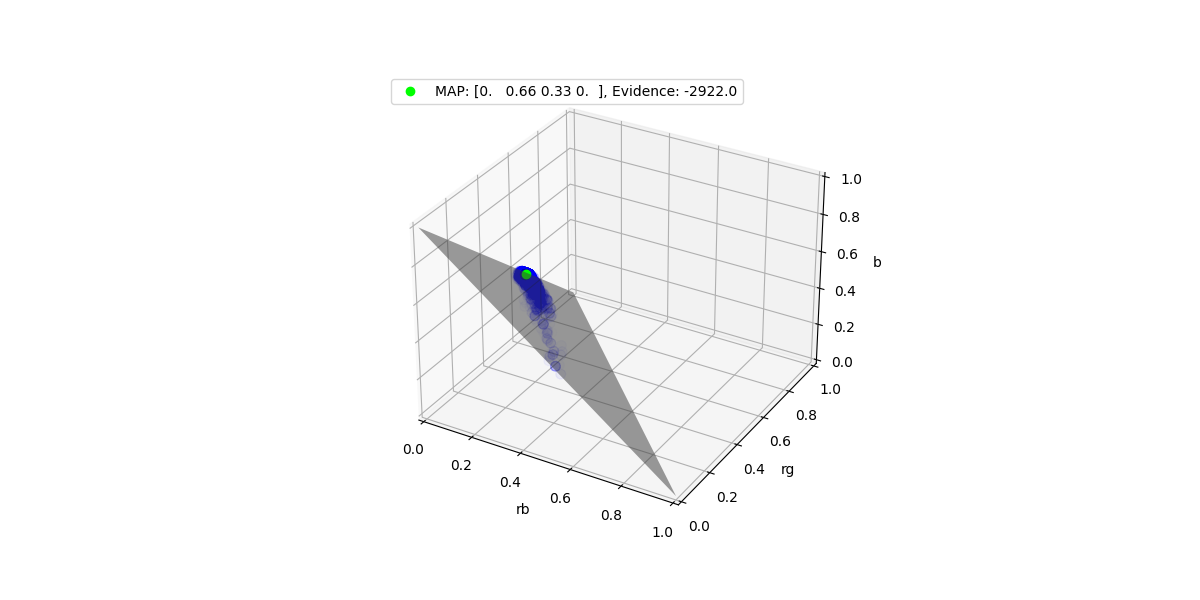

In [175]:
# Function to plot the samples with the specified index
import tikzplotlib
plt.close()
fig4 = plt.figure()
ax4 = fig4.add_subplot(projection='3d')
fig4.set_size_inches(12, 6)

def plot_sample(sample_index):
    sample_index = int(sample_index)

    samps = np.concatenate((burnin_samples_array2, samples_array2))
    ax = ax4
    
    ax.cla()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.set_xlabel('rb')
    ax.set_ylabel('rg')
    ax.set_zlabel('b')
    ax.grid(True)
    ax.plot_trisurf([1,0,0], [0,1,0], [0,0,1], color='grey', alpha=0.5)

    ax.scatter(xs=samps[:sample_index, 0], ys=samps[:sample_index, 1], zs=samps[:sample_index, 2], s=50, c='red', alpha=0.01)
    ax.scatter(xs=samps[sample_index:, 0], ys=samps[sample_index:, 1], zs=samps[sample_index:, 2], s=50, c='blue', alpha=0.01)

    maps = np.zeros(len(map_estimate_list) - sample_index)
    for i, entry in zip(np.arange(len(map_estimate_list) - sample_index), map_estimate_list[sample_index:]):
        maps[i] = map_estimate_list[i][1]
    idx = np.argmax(maps)
    map = map_estimate_list[idx]
    
    ax.plot(xs=map[0][0], ys=map[0][1], zs=map[0][2], marker = 'o', markersize=6, c='lime', alpha=1,
           label=f'MAP: {np.round(map[0],2)}, Evidence: {np.round(map[1])}', linestyle = '', zorder=5)
    ax.scatter(0,0.66,0.33, s=50, c='yellow')
    ax.legend(loc='upper left')
    return 0

# Create an interactive plot with slider
iplt.plot(plot_sample, sample_index=(0, len(np.concatenate((burnin_samples_array2, samples_array2))) - 1))


# Sparse Prior (2)

In [11]:
# init prior distribution
a = np.array(4*[0.1])
prior = dirichlet(a)

In [12]:
%%time

init_state = np.random.dirichlet(np.ones(4))
init_state = np.array([0.33, 0.33, 0.17, 0.17])
print(init_state)
samples, burnin_samples, accepted_samples, map_estimate, map_estimate_list = metropolis_hastings(init_state, calc_values, 1000, 0.5, dirichlet_proposal)
print(map_estimate)
print(len(accepted_samples))

samples_array6 = np.array(samples)
burnin_samples_array6 = np.array(burnin_samples)

[0.33 0.33 0.17 0.17]


C:\Users\Max\Documents\Master_Würzburg\Hydras\mixed_trails\mixed_env\lib\site-packages\scipy\stats\_multivariate.py:1633: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


[array([2.67920030e-05, 6.58066255e-01, 3.41774311e-01, 1.32642567e-04]), -2921.8742776383842]
104
CPU times: total: 1min 12s
Wall time: 1min 14s


TypeError: Axes3D.plot() missing 1 required positional argument: 'ys'

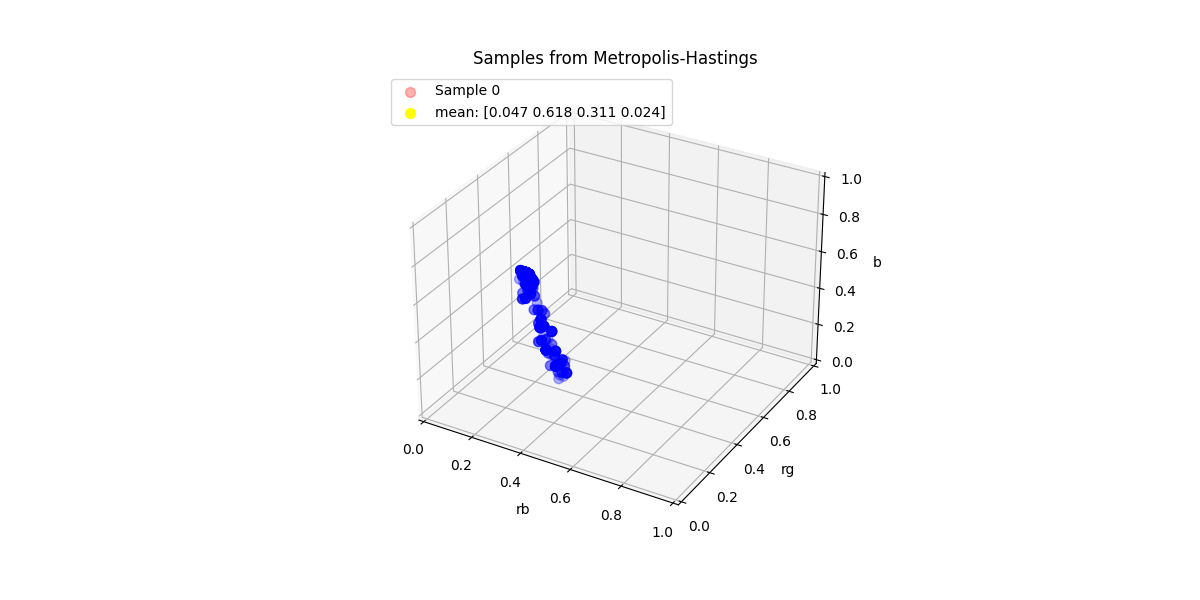

In [171]:
# Function to plot the samples with the specified index
plt.close()
fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
fig2.set_size_inches(12, 6)

def plot_sample(sample_index):
    sample_index = int(sample_index)

    samps = np.concatenate((burnin_samples_array6, samples_array6))
    ax = ax2
    
    ax.cla()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.set_title('Samples from Metropolis-Hastings')
    ax.set_xlabel('rb')
    ax.set_ylabel('rg')
    ax.set_zlabel('b')
    ax.grid(True)

    ax.scatter(xs=samps[:sample_index, 0], ys=samps[:sample_index, 1], zs=samps[:sample_index, 2], s=50, c='red', alpha=0.3, label=f'Sample {sample_index}')
    ax.scatter(xs=samps[sample_index:, 0], ys=samps[sample_index:, 1], zs=samps[sample_index:, 2], s=50, c='blue', alpha=0.3)
    
    curr_mean = np.round(np.mean(samps[sample_index:, :], axis=0), 3)
    ax.scatter(xs=curr_mean[0], ys=curr_mean[1], zs=curr_mean[2], s=50, c='yellow', alpha=1, label=f'mean: {curr_mean}')

    ax.legend(loc='upper left')
    return 0

# Create an interactive plot with slider
iplt.plot(plot_sample, sample_index=(0, len(np.concatenate((burnin_samples_array6, samples_array6))) - 1))

# Sparse Prior and Sparse Proposal

In [14]:
# dirichlet proposal distribution
def dirichlet_proposal(curr_state, alpha_prop=0.8):
    proposed_state = dirichlet.rvs(alpha=4*[alpha_prop], size=1).reshape(len(curr_state))  
    #proposed_state = dirichlet.rvs(alpha=curr_state*concentration_factor, size=1).reshape(len(curr_state)) 
    # problem: dirichlet samples with zero entries cannot be used as new parameters for the dirichlet proposal dist
    mask = (proposed_state == 0)
    proposed_state[mask] = 0.001
    counts = mask.sum()
    proposed_state[np.argmax(proposed_state)] -= counts * 0.001

    proposal_ratio = dirichlet.pdf(curr_state, 4*[alpha_prop]) / dirichlet.pdf(proposed_state, 4*[alpha_prop])
    
    return proposed_state, proposal_ratio

In [15]:
# init prior distribution
a = np.array(4*[0.1])
prior = dirichlet(a)

In [16]:
%%time

init_state = np.random.dirichlet(np.ones(4))
print(init_state)
samples, burnin_samples, accepted_samples, map_estimate, map_estimate_list = metropolis_hastings(init_state, calc_values, 1000, 0.5, dirichlet_proposal)
print(map_estimate)
print(len(accepted_samples))

samples_array3 = np.array(samples)
burnin_samples_array3 = np.array(burnin_samples)

[0.05674116 0.70137459 0.01017691 0.23170734]
[array([0.65332806, 0.05392762, 0.00128578, 0.29145854]), -2922.6960297753913]
17
CPU times: total: 1min 7s
Wall time: 1min 7s


TypeError: Axes3D.plot() missing 1 required positional argument: 'ys'

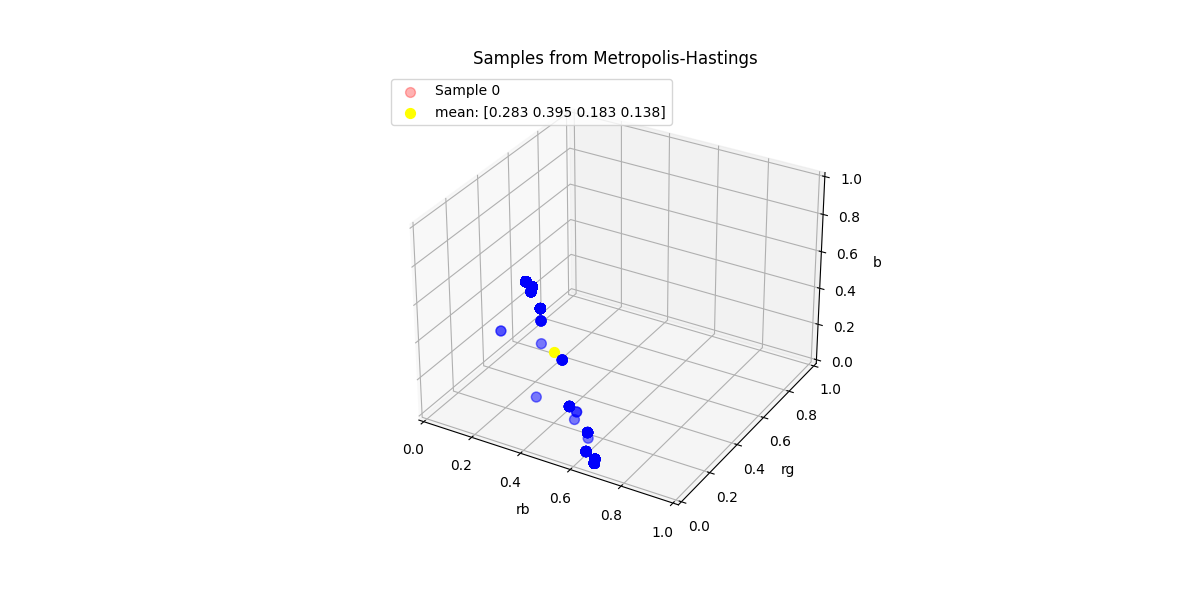

In [172]:
# Function to plot the samples with the specified index
plt.close()
fig5 = plt.figure()
ax5 = fig5.add_subplot(projection='3d')
fig5.set_size_inches(12, 6)

def plot_sample(sample_index):
    sample_index = int(sample_index)

    samps = np.concatenate((burnin_samples_array3, samples_array3))
    ax = ax5
    
    ax.cla()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.set_title('Samples from Metropolis-Hastings')
    ax.set_xlabel('rb')
    ax.set_ylabel('rg')
    ax.set_zlabel('b')
    ax.grid(True)

    ax.scatter(xs=samps[:sample_index, 0], ys=samps[:sample_index, 1], zs=samps[:sample_index, 2], s=50, c='red', alpha=0.3, label=f'Sample {sample_index}')
    ax.scatter(xs=samps[sample_index:, 0], ys=samps[sample_index:, 1], zs=samps[sample_index:, 2], s=50, c='blue', alpha=0.3)
    
    curr_mean = np.round(np.mean(samps[sample_index:, :], axis=0), 3)
    ax.scatter(xs=curr_mean[0], ys=curr_mean[1], zs=curr_mean[2], s=50, c='yellow', alpha=1, label=f'mean: {curr_mean}')

    ax.legend(loc='upper left')
    return 0

# Create an interactive plot with slider
iplt.plot(plot_sample, sample_index=(0, len(np.concatenate((burnin_samples_array3, samples_array3))) - 1))

# Sparse Prior and Sparse Proposal (2)

In [18]:
# dirichlet proposal distribution
def dirichlet_proposal(curr_state, alpha_prop=0.5):
    proposed_state = dirichlet.rvs(alpha=4*[alpha_prop], size=1).reshape(len(curr_state))  
    #proposed_state = dirichlet.rvs(alpha=curr_state*concentration_factor, size=1).reshape(len(curr_state)) 
    # problem: dirichlet samples with zero entries cannot be used as new parameters for the dirichlet proposal dist
    mask = (proposed_state == 0)
    proposed_state[mask] = 0.001
    counts = mask.sum()
    proposed_state[np.argmax(proposed_state)] -= counts * 0.001

    proposal_ratio = dirichlet.pdf(curr_state, 4*[alpha_prop]) / dirichlet.pdf(proposed_state, 4*[alpha_prop])
    
    return proposed_state, proposal_ratio

In [19]:
# init prior distribution
a = np.array(4*[0.1])
prior = dirichlet(a)

In [20]:
%%time

init_state = np.random.dirichlet(np.ones(4))
print(init_state)
samples, burnin_samples, accepted_samples, map_estimate, map_estimate_list = metropolis_hastings(init_state, calc_values, 10000, 0.5, dirichlet_proposal)
print(map_estimate)
print(len(accepted_samples))

samples_array4 = np.array(samples)
burnin_samples_array4 = np.array(burnin_samples)

[0.37593955 0.15614435 0.13961492 0.32830118]
[array([0.57370587, 0.11148084, 0.04049389, 0.27431941]), -2922.0187876264645]
81
CPU times: total: 11min 28s
Wall time: 11min 34s


TypeError: Axes3D.plot() missing 1 required positional argument: 'ys'

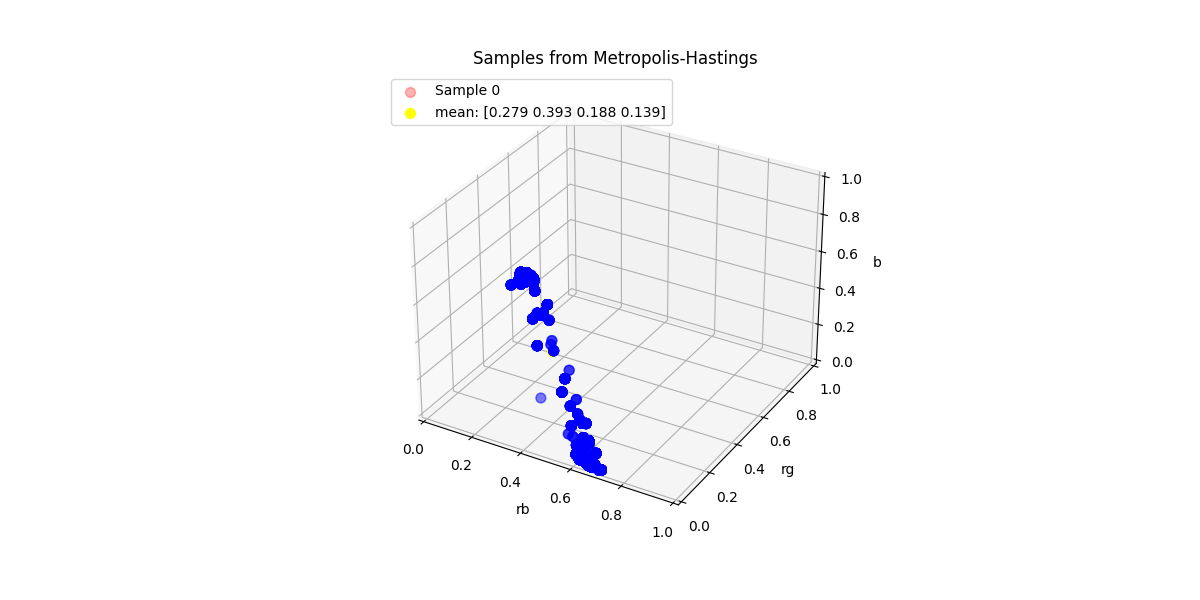

In [173]:
# Function to plot the samples with the specified index
plt.close()
fig6 = plt.figure()
ax6 = fig6.add_subplot(projection='3d')
fig6.set_size_inches(12, 6)

def plot_sample(sample_index):
    sample_index = int(sample_index)

    samps = np.concatenate((burnin_samples_array4, samples_array4))
    ax = ax6
    
    ax.cla()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.set_title('Samples from Metropolis-Hastings')
    ax.set_xlabel('rb')
    ax.set_ylabel('rg')
    ax.set_zlabel('b')
    ax.grid(True)

    ax.scatter(xs=samps[:sample_index, 0], ys=samps[:sample_index, 1], zs=samps[:sample_index, 2], s=50, c='red', alpha=0.3, label=f'Sample {sample_index}')
    ax.scatter(xs=samps[sample_index:, 0], ys=samps[sample_index:, 1], zs=samps[sample_index:, 2], s=50, c='blue', alpha=0.3)
    
    curr_mean = np.round(np.mean(samps[sample_index:, :], axis=0), 3)
    ax.scatter(xs=curr_mean[0], ys=curr_mean[1], zs=curr_mean[2], s=50, c='yellow', alpha=1, label=f'mean: {curr_mean}')

    ax.legend(loc='upper left')
    return 0

# Create an interactive plot with slider
iplt.plot(plot_sample, sample_index=(0, len(np.concatenate((burnin_samples_array4, samples_array4))) - 1))

# Proposal from Sum

In [30]:
# dirichlet proposal distribution
def dirichlet_proposal(curr_state, alpha_prop=0.5):
    acceptance_threshold = np.random.uniform(0, 1)
    if acceptance_threshold < 1/2:
        proposed_state = dirichlet.rvs(alpha=[6, 1, 1, 4], size=1).reshape(len(curr_state))  
        # problem: dirichlet samples with zero entries cannot be used as new parameters for the dirichlet proposal dist
        mask = (proposed_state == 0)
        proposed_state[mask] = 0.001
        counts = mask.sum()
        proposed_state[np.argmax(proposed_state)] -= counts * 0.001

        #proposal_ratio = dirichlet.pdf(curr_state, alpha=[6, 1, 1, 4]) / dirichlet.pdf(proposed_state, alpha=[6, 1, 1, 4])
    else : 
        proposed_state = dirichlet.rvs(alpha=[1, 6, 4, 1], size=1).reshape(len(curr_state)) 
        # problem: dirichlet samples with zero entries cannot be used as new parameters for the dirichlet proposal dist
        mask = (proposed_state == 0)
        proposed_state[mask] = 0.001
        counts = mask.sum()
        proposed_state[np.argmax(proposed_state)] -= counts * 0.001

        #proposal_ratio = dirichlet.pdf(curr_state, 4*[alpha_prop]) / dirichlet.pdf(proposed_state, 4*[alpha_prop])

    proposal_ratio = (1/2 * dirichlet.pdf(curr_state, alpha=[6, 1, 1, 4]) + 1/2 * dirichlet.pdf(curr_state, alpha=[1, 6, 4, 1]) )/ (1/2 * dirichlet.pdf(proposed_state, alpha=[6, 1, 1, 4]) + 1/2 * dirichlet.pdf(proposed_state, alpha=[1, 6, 4, 1]) )
    
    return proposed_state, proposal_ratio

In [31]:
# init prior distribution
a = np.array(4*[0.1])
prior = dirichlet(a)

In [32]:
%%time

init_state = np.random.dirichlet(np.ones(4))
print(init_state)
samples, burnin_samples, accepted_samples, map_estimate, map_estimate_list = metropolis_hastings(init_state, calc_values, 10000, 0.5, dirichlet_proposal)
print(map_estimate)
print(len(accepted_samples))

samples_array5 = np.array(samples)
burnin_samples_array5 = np.array(burnin_samples)

[0.05621636 0.64069582 0.07403092 0.2290569 ]
[array([4.33330206e-03, 6.61535637e-01, 3.34036549e-01, 9.45115546e-05]), -2942.7444114996465]
212
CPU times: total: 10min 15s
Wall time: 12min 42s


TypeError: Axes3D.plot() missing 1 required positional argument: 'ys'

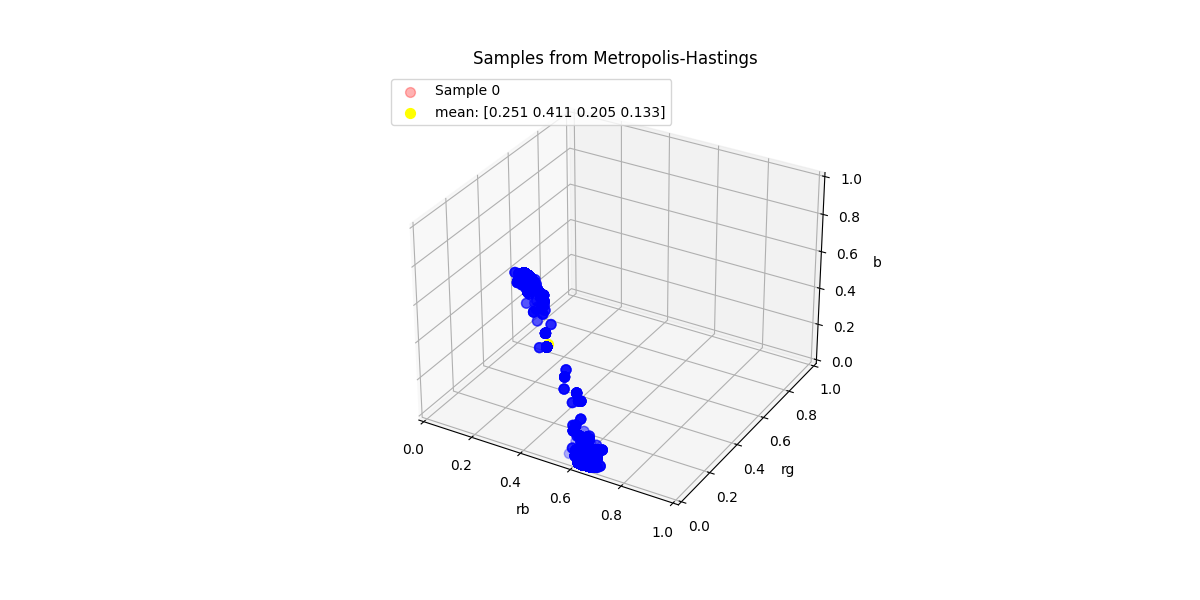

In [80]:
# Function to plot the samples with the specified index
plt.close()
fig8 = plt.figure()
ax8 = fig8.add_subplot(projection='3d')
fig8.set_size_inches(12, 6)

def plot_sample(sample_index):
    sample_index = int(sample_index)

    samps = np.concatenate((burnin_samples_array5, samples_array5))
    ax = ax8
    
    ax.cla()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.set_title('Samples from Metropolis-Hastings')
    ax.set_xlabel('rb')
    ax.set_ylabel('rg')
    ax.set_zlabel('b')
    ax.grid(True)

    ax.scatter(xs=samps[:sample_index, 0], ys=samps[:sample_index, 1], zs=samps[:sample_index, 2], s=50, c='red', alpha=0.3, label=f'Sample {sample_index}')
    ax.scatter(xs=samps[sample_index:, 0], ys=samps[sample_index:, 1], zs=samps[sample_index:, 2], s=50, c='blue', alpha=0.3)
    
    curr_mean = np.round(np.mean(samps[sample_index:, :], axis=0), 3)
    ax.scatter(xs=curr_mean[0], ys=curr_mean[1], zs=curr_mean[2], s=50, c='yellow', alpha=1, label=f'mean: {curr_mean}')

    ax.legend(loc='upper left')
    return 0

# Create an interactive plot with slider
iplt.plot(plot_sample, sample_index=(0, len(np.concatenate((burnin_samples_array5, samples_array5))) - 1))

In [280]:
proposed_states1 = np.array(dirichlet.rvs(alpha=[6, 1, 1, 4], size=1000))
proposed_states2 = np.array(dirichlet.rvs(alpha=[1, 6, 4, 1], size=1000))

proposed_states3 = np.concatenate([proposed_states1, proposed_states2], axis=0)

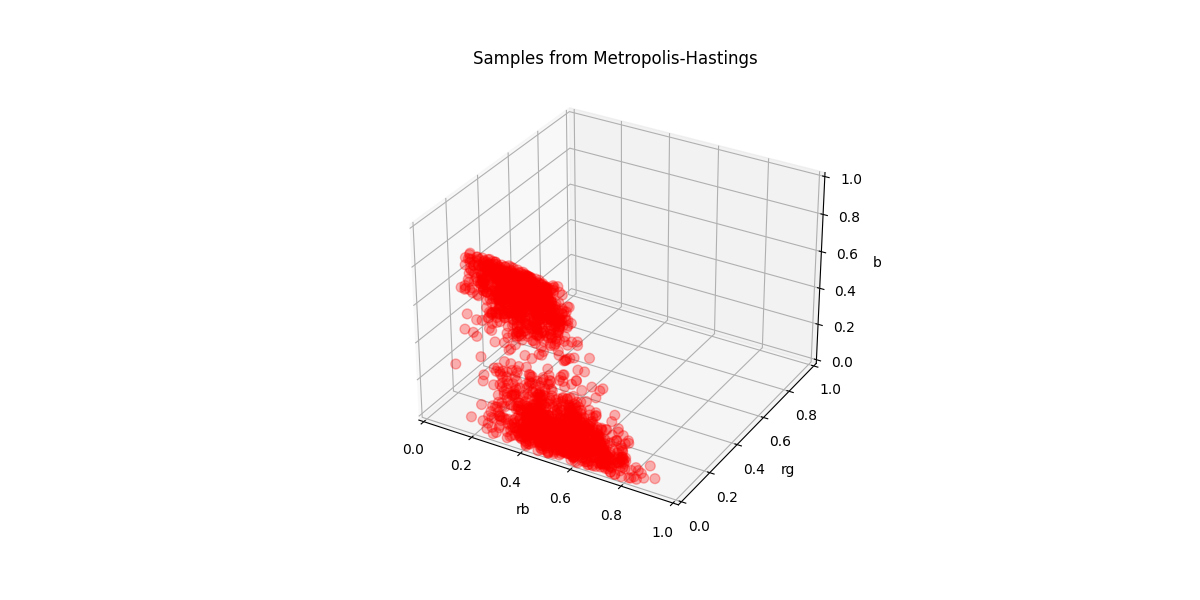

In [281]:
# Function to plot the samples with the specified index
plt.close()
fig7 = plt.figure()
ax7 = fig7.add_subplot(projection='3d')
fig7.set_size_inches(12, 6)
   
ax7.cla()
ax7.set_xlim(0, 1)
ax7.set_ylim(0, 1)
ax7.set_zlim(0, 1)
ax7.set_title('Samples from Metropolis-Hastings')
ax7.set_xlabel('rb')
ax7.set_ylabel('rg')
ax7.set_zlabel('b')
ax7.grid(True)

ax7.scatter(xs=proposed_states3[:, 0], ys=proposed_states3[:, 1], zs=proposed_states3[:, 2], s=50, c='red', alpha=0.3)